In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [2]:
# Step 1: Load the data
data = pd.read_csv('../roi_data_pn_3_processed.csv')

# Find the column labeled 'Label'
X = data.drop(['filename', 'Breed', 'Label'], axis=1)
y = data['Label']


In [3]:
X.shape

(260, 600)

In [4]:
def string_to_reshaped_array(s):
    array_np = string_to_array(s)
    return array_np.reshape(int(array_np.shape[0]**0.5), int(array_np.shape[0]**0.5), 1)

def string_to_array(s):
    # Remove unnecessary characters and split the string into lines
    clean_str = s.replace('[', '').replace(']', '').strip()
    lines = clean_str.split('\n')

    # Process each line to convert it into a list of numbers
    array_list = []
    for line in lines:
        numbers = [int(num.strip()) for num in line.split() if num.strip().isdigit()]
        if len(numbers) > 0:
            array_list.append(numbers)

    # Convert the list of lists into a numpy array and reshape
    array_np = np.array(array_list)
    return array_np

def normalize_curves(curves):
    min_values = [np.min(curve) for curve in curves]
    min_value = np.min(min_values)
    return [curve - np.min(curve) + min_value for curve in curves]

In [5]:
X_df = X.applymap(string_to_array)

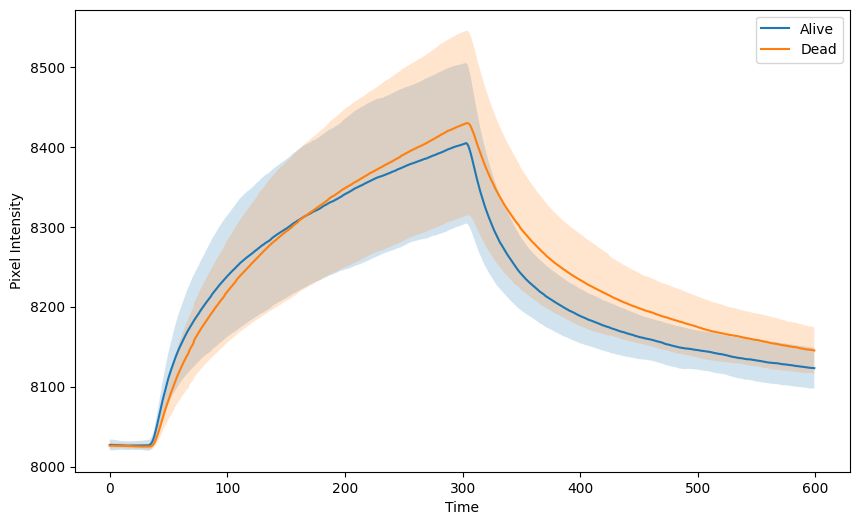

In [6]:
# get all means and stds
means = []
for i in range(X_df.shape[0]):
    mean = []
    for j in range(X_df.shape[1]):
        data = X_df.iloc[i, j]
        mean.append(np.mean(data))
    means.append(mean)


# Convert 'means' and 'stds' lists to numpy arrays for easier manipulation
means = np.array(normalize_curves(means))
half_index = int(means.shape[0] / 2)-1

mean_alive = np.mean(means[:half_index], axis=0)
mean_dead = np.mean(means[half_index:], axis=0)
std_alive = np.std(means[:half_index], axis=0)
std_dead = np.std(means[half_index:], axis=0)

# Plotting
plt.figure(figsize=(10, 6))

# Plot for 'Alive'
plt.plot(mean_alive, label='Alive')
plt.fill_between(range(len(mean_alive)), 
                 mean_alive - std_alive, 
                 mean_alive + std_alive, 
                 alpha=0.2)

# Plot for 'Dead'
plt.plot(mean_dead, label='Dead')
plt.fill_between(range(len(mean_dead)), 
                 mean_dead - std_dead, 
                 mean_dead + std_dead, 
                 alpha=0.2)

# Setting labels and legend
plt.xlabel('Time')
plt.ylabel('Pixel Intensity')
plt.legend()
plt.show()

In [7]:
# Apply the conversion function to each cell in the DataFrame
X_processed = X.applymap(string_to_reshaped_array)

# Initialize an empty list to hold the flattened arrays
X_flattened_list = []

# Iterate through each row
for _, row in X_processed.iterrows():
    # Flatten each non-NaN element and append to the list
    row_flattened = [element.flatten() for element in row if isinstance(element, np.ndarray)]
    if row_flattened:  # If row is not empty
        X_flattened_list.append(np.concatenate(row_flattened))

# Convert the list of flattened arrays to a NumPy array
X_flattened = np.array(X_flattened_list)


Decision Tree

In [8]:
# Create a Decision Tree Classifier
clf = DecisionTreeClassifier()

# Use k-fold cross-validation (e.g., k=5)
cv_scores = cross_val_score(clf, X_flattened, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.3, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model using different metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Cross-validation scores: [0.73076923 0.69230769 0.73076923 0.73076923 0.75      ]
Mean cross-validation score: 0.7269230769230769
Classification Report:
               precision    recall  f1-score   support

       False       0.79      0.79      0.79        39
        True       0.79      0.79      0.79        39

    accuracy                           0.79        78
   macro avg       0.79      0.79      0.79        78
weighted avg       0.79      0.79      0.79        78

Confusion Matrix:
 [[31  8]
 [ 8 31]]


Random Forest

In [9]:
clf = RandomForestClassifier()

# Use the same cross-validation approach
cv_scores = cross_val_score(clf, X_flattened, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.3, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model using different metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Cross-validation scores: [0.84615385 0.82692308 0.76923077 0.80769231 0.86538462]
Mean cross-validation score: 0.823076923076923
Classification Report:
               precision    recall  f1-score   support

       False       0.79      0.77      0.78        39
        True       0.78      0.79      0.78        39

    accuracy                           0.78        78
   macro avg       0.78      0.78      0.78        78
weighted avg       0.78      0.78      0.78        78

Confusion Matrix:
 [[30  9]
 [ 8 31]]


In [10]:
clf = LogisticRegression()

# Use the same cross-validation approach
cv_scores = cross_val_score(clf, X_flattened, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.3, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model using different metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Cross-validation scores: [0.80769231 0.80769231 0.88461538 0.71153846 0.82692308]
Mean cross-validation score: 0.8076923076923077
Classification Report:
               precision    recall  f1-score   support

       False       0.83      0.87      0.85        39
        True       0.86      0.82      0.84        39

    accuracy                           0.85        78
   macro avg       0.85      0.85      0.85        78
weighted avg       0.85      0.85      0.85        78

Confusion Matrix:
 [[34  5]
 [ 7 32]]


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
clf = SVC()

# Use the same cross-validation approach
cv_scores = cross_val_score(clf, X_flattened, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.3, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model using different metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Cross-validation scores: [0.78846154 0.84615385 0.76923077 0.80769231 0.82692308]
Mean cross-validation score: 0.8076923076923077
Classification Report:
               precision    recall  f1-score   support

       False       0.79      0.77      0.78        39
        True       0.78      0.79      0.78        39

    accuracy                           0.78        78
   macro avg       0.78      0.78      0.78        78
weighted avg       0.78      0.78      0.78        78

Confusion Matrix:
 [[30  9]
 [ 8 31]]


In [12]:
clf = KNeighborsClassifier()

# Use the same cross-validation approach
cv_scores = cross_val_score(clf, X_flattened, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.3, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model using different metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Cross-validation scores: [0.76923077 0.71153846 0.67307692 0.80769231 0.76923077]
Mean cross-validation score: 0.7461538461538462
Classification Report:
               precision    recall  f1-score   support

       False       0.80      0.72      0.76        39
        True       0.74      0.82      0.78        39

    accuracy                           0.77        78
   macro avg       0.77      0.77      0.77        78
weighted avg       0.77      0.77      0.77        78

Confusion Matrix:
 [[28 11]
 [ 7 32]]
